# SC1015 B125 Data Science Project (latest: 1011pm)
# Title: Dating App Advice (for girls)
### Authors: Luar Shui Yan, Tan Yong Jie, Leonard Ong Kai Jun


**Importing essential libraries** 

In [1]:
#7pm 7 March
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import statsmodels.api as sm
import pylab as py
from scipy.stats import norm

#sklearn libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from sklearn import datasets
iris = datasets.load_iris()
samples = iris.data

## Section 1: Data Preparation & Cleaning

First, we read our csv dataset into a pandas dataframe. <br>
We then inspect df.shape to see the number of rows and columns of the raw dataset. <br>
We see that there are, before any data processing, 3992 rows and 42 columns.

In [2]:
df = pd.read_csv("LovooCSV.csv")
print("Number of rows: ",df.shape[0])
print("\nNumber of columns: ", df.shape[1])

Number of rows:  3992

Number of columns:  42


Next, we use df.head() to see the columns. <br>
Of the 42 columns, we have decided on only a few:
1. Response variable: counts_kisses; this variable is the number of "kisses" users received on the app, and indicates dating interest from their matches. We will use this to measure their "success" on the app.
2. Numeric predictors: age, counts_pictures, lang_count
    - age: the age of the user. Ranges from 18 to 25
    - counts_pictures: number of pictures put up by user on their profile
    - lang_count: number of languages user is proficient in.
3. Categorical predictors: genderLooking, isVip, country
    - genderLooking: the gender the user is interested in dating.
    - isVip: a binary variable whether the user is subscribed to the paid premium features of this app.
    - country: the country the user is in - largely central European countries such as Switzerland, France, Germany.

In [3]:
df.head()

,gender,genderLooking,age,name,counts_details,counts_pictures,counts_profileVisits,counts_kisses,counts_fans,counts_g,...,shareProfileEnabled,lastOnlineDate,lastOnlineTime,birthd,crypt,freetext,whazzup,userId,pictureId,isSystemProfile
0,F,M,25.0,daeni,1.00,4,8279,239,0,3,...,1,2015-04-25T20:43:26Z,1.429995e+09,0,NaN,Nur tote Fisch schwimmen mit dem Strom,Nur tote fische schwimmen mit dem strom,4e3842f79b70e7ea57000064,55303fc3160ba0eb728b4575,NaN
1,F,M,22.0,italiana 92,0.85,5,663,13,0,0,...,1,2015-04-26T09:19:35Z,1.430040e+09,0,NaN,NaN,Primaveraaa<3,4e3d34bf5d2bce7b160006a3,552e7b61c66da10d1e8b4c82,NaN
2,F,M,21.0,Lauraaa,0.00,4,1369,88,0,2,...,1,2015-04-06T14:24:07Z,1.428330e+09,0,NaN,NaN,NaN,4ec96c090dc82cb25d00000a,54a584ecc56da128638b4674,NaN
3,F,none,20.0,Qqkwmdowlo,0.12,3,22187,1015,2,3,...,1,2015-04-07T11:21:01Z,1.428406e+09,0,NaN,NaN,Je pense donc je suis. Instagram quedev,4eef8b81ebf2c8f64000000c,54c92738076ea1b5338b4735,NaN
4,F,M,21.0,schaessie {3,0.15,12,35262,1413,9,12,...,1,2015-04-06T14:25:20Z,1.428330e+09,0,NaN,NaN,Instagram: JESSSIESCH,4ef3cc5aa9d0b3d07d000017,54e1a6f6c76da135748b4a3a,NaN


We will rename our column names to sound more intuitive to what they represent.<br>
- counts_kisses ==> numLikes
- counts_pictures ==> numPictures
- lang_count ==> numLang (for continuity)

In [4]:
df = df.rename({'counts_kisses': 'numLikes', 'counts_pictures': 'numPictures', 'lang_count': 'numLang'}, axis=1)

In [5]:
df1 = df.loc[:,['genderLooking', 'age', 'country', 'numPictures', 'numLikes', 'numLang', 'isVip']]
df1.head()

,genderLooking,age,country,numPictures,numLikes,numLang,isVip
0,M,25.0,CH,4,239,1,0
1,M,22.0,CH,5,13,3,0
2,M,21.0,CH,4,88,0,0
3,none,20.0,CA,3,1015,2,0
4,M,21.0,DE,12,1413,1,0


### Data Cleaning
We will start by removing NaN rows and duplicate rows <br>
Note: for genderLooking, "none" means the user is looking for a nonbinary dating partner, and does not mean a null entry. <br>
In fact, the only column with null entries is the "age" column.

In [6]:
df1['age'].isna().sum()

7

In [7]:
df1.dropna(subset=['age'])
df1 = df1.drop_duplicates()

Next, we wish for our research to be targeted towards young women from 18-25, and as such will filter out the age group like so.

In [8]:
df1 = df1[(df1['age'] >= 18) & (df1['age'] <= 25)]
df1.shape

(3503, 7)

Next, we move on to the genderLooking column. In this column we observe the following possible values:
- M, male
- F, female
- none, neither M nor F
- both, both M & F


In [9]:
df1['genderLooking'].value_counts()

M       3111
none     348
F         25
both      19
Name: genderLooking, dtype: int64

For the purposes of this study, we will convert this column into a binary variable, with women looking for only men as "1" and otherwise as "0"

In [10]:
mapping = {'M': 1, 'none': 0, 'F': 0, 'both': 0, np.nan: 0}
df1['genderLooking'] = df1['genderLooking'].map(mapping)
df1['genderLooking'].value_counts()

1    3111
0     392
Name: genderLooking, dtype: int64

The country column is similar in distribution to genderLooking:

In [11]:
df1['country'].value_counts()

CH    1538
DE    1172
FR     596
IT     130
AT      13
BE       6
ES       6
LU       5
US       3
TR       3
BA       3
RO       2
RU       2
BR       2
CA       2
AU       2
NL       2
SC       2
LI       1
LR       1
ID       1
JM       1
ET       1
HU       1
AR       1
GB       1
PE       1
UA       1
IN       1
CZ       1
PH       1
CF       1
Name: country, dtype: int64

For the purposes of this study, we will limit the countries to the 5 most numerous.<br>
CH - Switzerland<br>
DE - Germany<br>
FR - France<br>
IT - Italy<br>
AT - Austria

In [12]:
df1 = df1[df1['country'].map(df1['country'].value_counts()) >= 12]

Finally, we will also convert the isVip column into a binary **numerical** data like so:

In [13]:
df1 = df1.astype({'isVip': 'int'})
df1['isVip'].value_counts()

0    3360
1      89
Name: isVip, dtype: int64

## Section 2: Exploratory Data Analysis

### 2a: Numeric EDA
1. Univariate non-graphical
2. Univariate graphical
3. Multivariate graphical & nongraphical

1. **Univariate Non-graphical** <br>
For this section, we look at the statistical insights of our various numerical data types including the response variable. <br>
This is primarily to check for outliers by comparing the max/min against median for respective columns.

In [14]:
numeric_data = pd.DataFrame(df1[['numLikes', 'age', 'numPictures', 'numLang']])
numeric_data.describe().round(2)

,numLikes,age,numPictures,numLang
count,3449.00,3449.00,3449.00,3449.00
mean,168.47,21.84,5.06,1.12
std,389.53,1.86,4.48,0.60
min,0.00,18.00,0.00,0.00
25%,16.00,20.00,2.00,1.00
50%,53.00,22.00,4.00,1.00
75%,157.00,23.00,6.00,1.00
max,9288.00,25.00,30.00,9.00


Additionally we inspect skewness and kurtosis of each of these numeric data. <br><br>
Skewness indicates to us which side of the distribution tends to have more outliers (tail) <br>
A normal distribution has skewness = 0; Any skewness < -1 or > 1 suggests heavy skewing to left and right side respectively. <br><br>

Kurtosis indicates the number of outliers the distribution has. <br>
A normal distribution has kurtosis = 3; A kurtosis > 3 suggests more values to the extreme ends (more outliers) while kurtosis < 3 suggest less outliers than expected in a normal distribution.

In [15]:
lst = []
for col in numeric_data:
    print(col, '\n')
    sk = numeric_data[col].astype(float).skew()
    kt = numeric_data[col].astype(float).kurt()
    print("Skewness: ", round(sk, 4), "\n")
    print("Kurtosis: ", round(kt, 4), "\n\n")
    lst.append(sk)
    lst.append(kt)
lst

numLikes 

Skewness:  8.5725 

Kurtosis:  129.649 


age 

Skewness:  0.0522 

Kurtosis:  -1.08 


numPictures 

Skewness:  2.3359 

Kurtosis:  7.1768 


numLang 

Skewness:  4.3919 

Kurtosis:  28.8287 




[8.572457224530933,
 129.64901213765106,
 0.052189922894174776,
 -1.0799542352123654,
 2.335887541974034,
 7.176804100011213,
 4.391915729534323,
 28.82869878540797]

As can be seen, the other 3 numeric variables other than age are heavily skewed to the right (skew >> 1) <br>
The same can be concluded by observing how the max of these 3 variables are much larger than their median. <br>
Hence, we will fix this skew by removing some outliers using our custom function.<br>
**Note: we will not be removing outliers for age or for lang_count.**
- Age - There are roughly similar numbers of users per age from 18-25 and would be meaningless for us to remove outliers as such.
- Lang_count - due to majority of the users being monolingual, removing outliers would mean removing those who can speak 2 languages or more, rendering this column meaningless for further statistical analysis.

In [16]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in[(df_in[col_name] >= fence_low) & (df_in[col_name] <= fence_high)]
    return df_out

In [17]:
df1 = remove_outlier(df1, 'numLikes')
df1 = remove_outlier(df1, 'numPictures')
numeric_data = pd.DataFrame(df1[['numLikes', 'age', 'numPictures', 'numLang']])
numeric_data.describe().round(2)

,numLikes,age,numPictures,numLang
count,2948.00,2948.00,2948.00,2948.00
mean,72.21,21.90,3.99,1.09
std,82.02,1.86,2.57,0.55
min,0.00,18.00,0.00,0.00
25%,13.00,20.00,2.00,1.00
50%,39.00,22.00,4.00,1.00
75%,104.00,23.00,5.00,1.00
max,368.00,25.00,12.00,7.00


In [18]:
i = 0
for col in numeric_data:
    print(col, '\n')
    sk = numeric_data[col].astype(float).skew()
    kt = numeric_data[col].astype(float).kurt()
    print("Skewness: ", round(lst[i],4), "==>", round(sk, 4), "\n")
    i+=1
    print("Kurtosis: ", round(lst[i],4), "==>", round(kt, 4), "\n\n")
    i+=1


numLikes 

Skewness:  8.5725 ==> 1.5461 

Kurtosis:  129.649 ==> 1.7748 


age 

Skewness:  0.0522 ==> 0.0086 

Kurtosis:  -1.08 ==> -1.0658 


numPictures 

Skewness:  2.3359 ==> 0.9272 

Kurtosis:  7.1768 ==> 0.5101 


numLang 

Skewness:  4.3919 ==> 4.3777 

Kurtosis:  28.8287 ==> 28.2508 




We can see that the difference between median and max has reduced significantly, indicating removal of most extreme outliers.
This is corroborated further by reduction of skewness and kurtosis across the board

 2. **Univariate Graphical** <br>
In this subsection, we explore the distributions and patterns of our numeric datatypes (numLikes, age, numPictures, numLang)

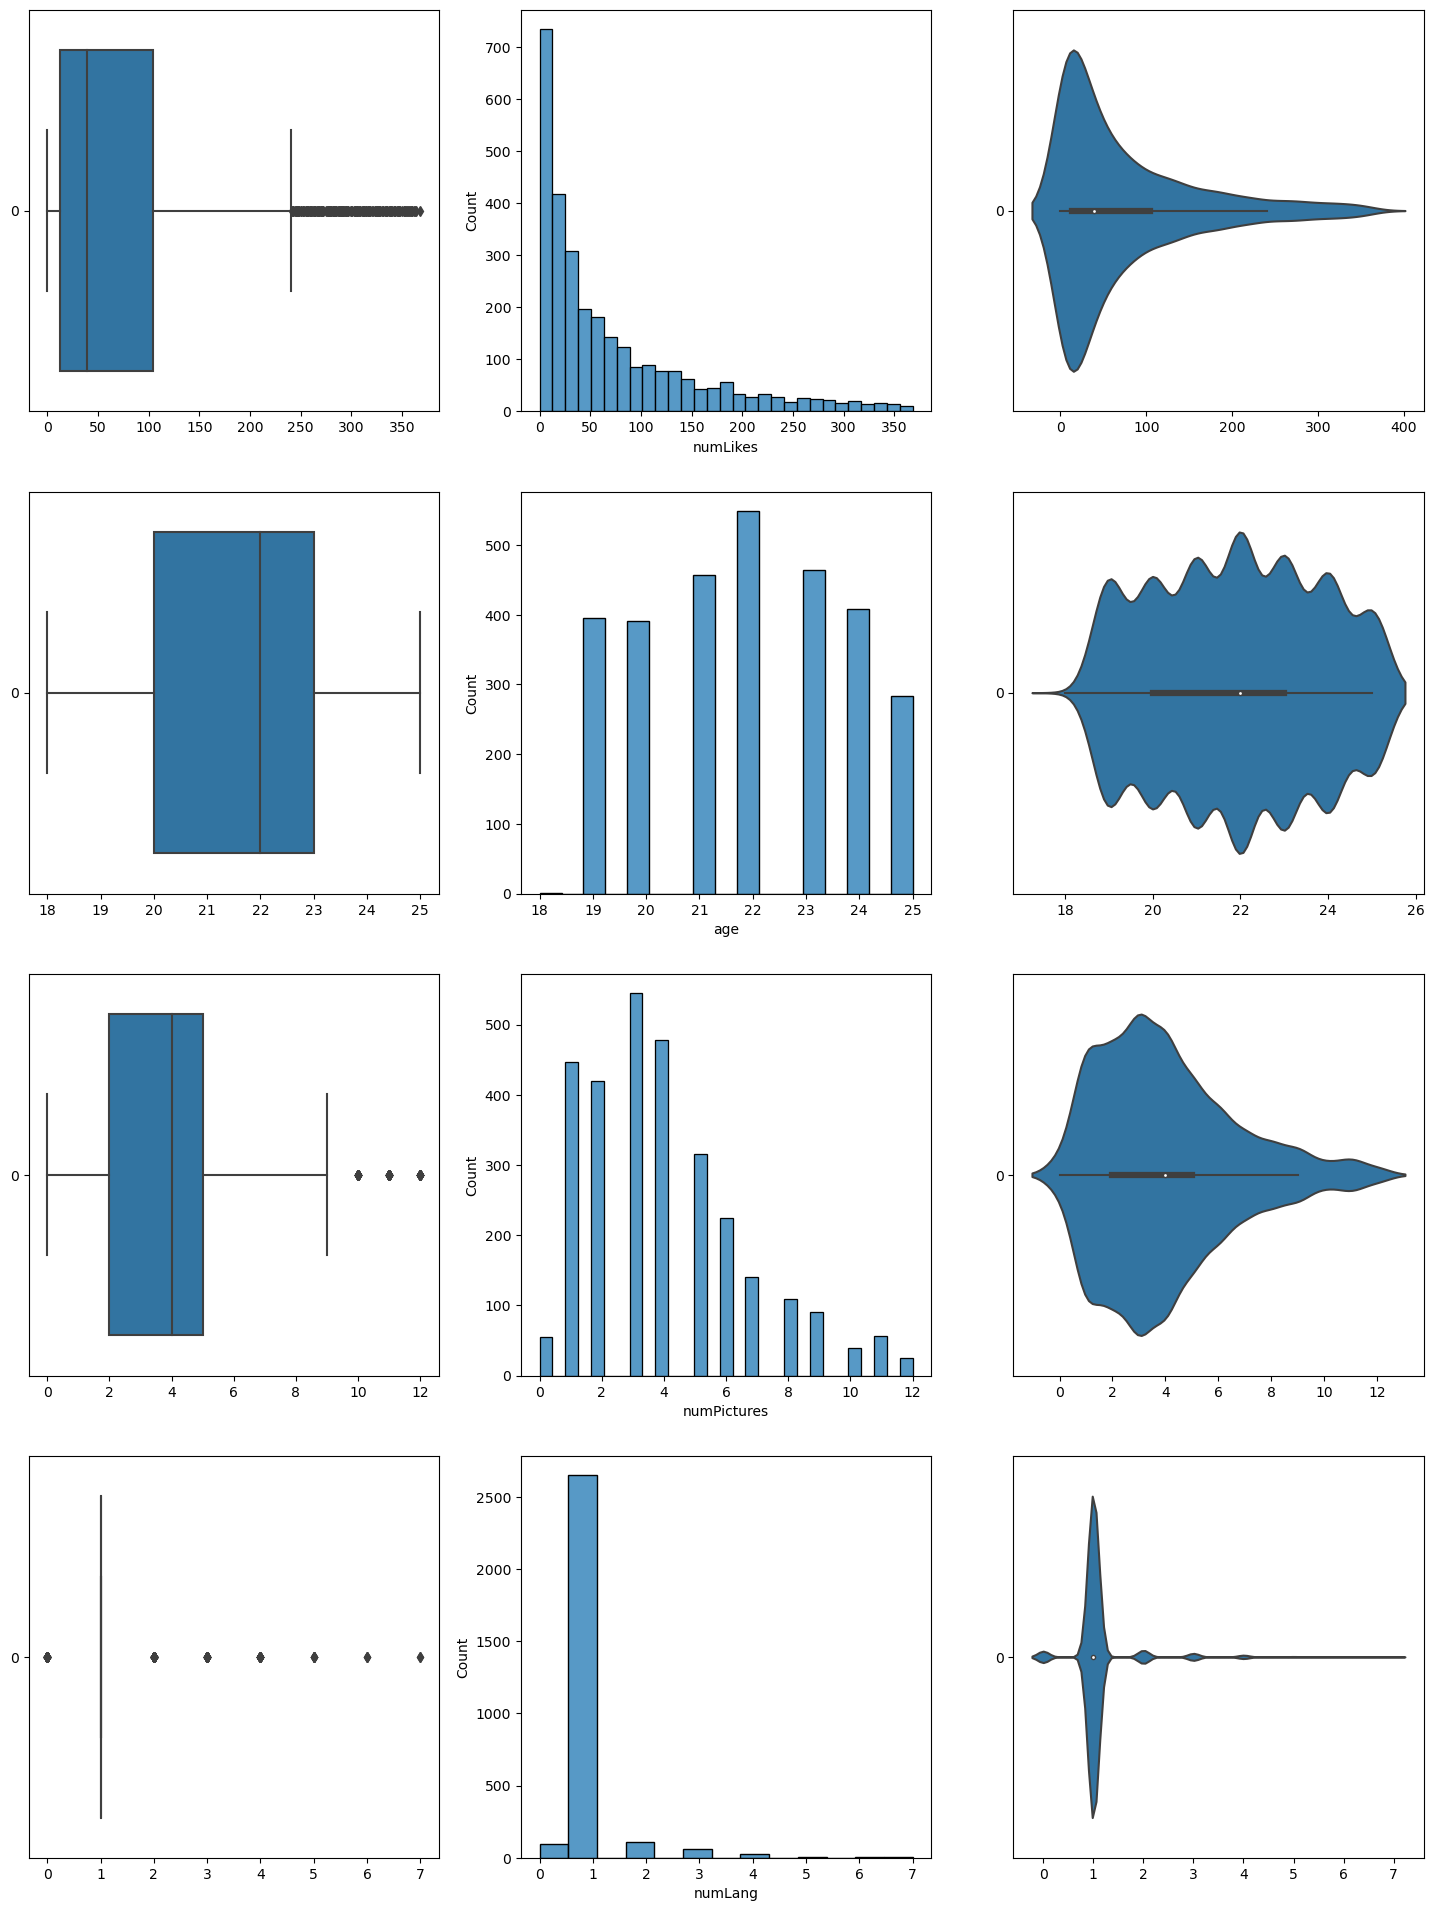

In [19]:
# Draw the distributions of all variables
f, axes = plt.subplots(4, 3, figsize=(18, 24))

count = 0
for var in numeric_data:
    sb.boxplot(data = numeric_data[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = numeric_data[var], ax = axes[count,1])
    sb.violinplot(data = numeric_data[var], orient = "h", ax = axes[count,2])
    count += 1

 3. **Multivariate Graphical/Nongraphical** <br>
Here we inspect the correlation between each pair of numeric variables.<br>
Our focus is of course, the first row (excluding first entry) enumerating the correlation coefficients for each of the predictors.

             numLikes       age  numPictures   numLang
numLikes     1.000000 -0.075525     0.283009  0.096860
age         -0.075525  1.000000    -0.069964 -0.011989
numPictures  0.283009 -0.069964     1.000000  0.056546
numLang      0.096860 -0.011989     0.056546  1.000000


<AxesSubplot:>

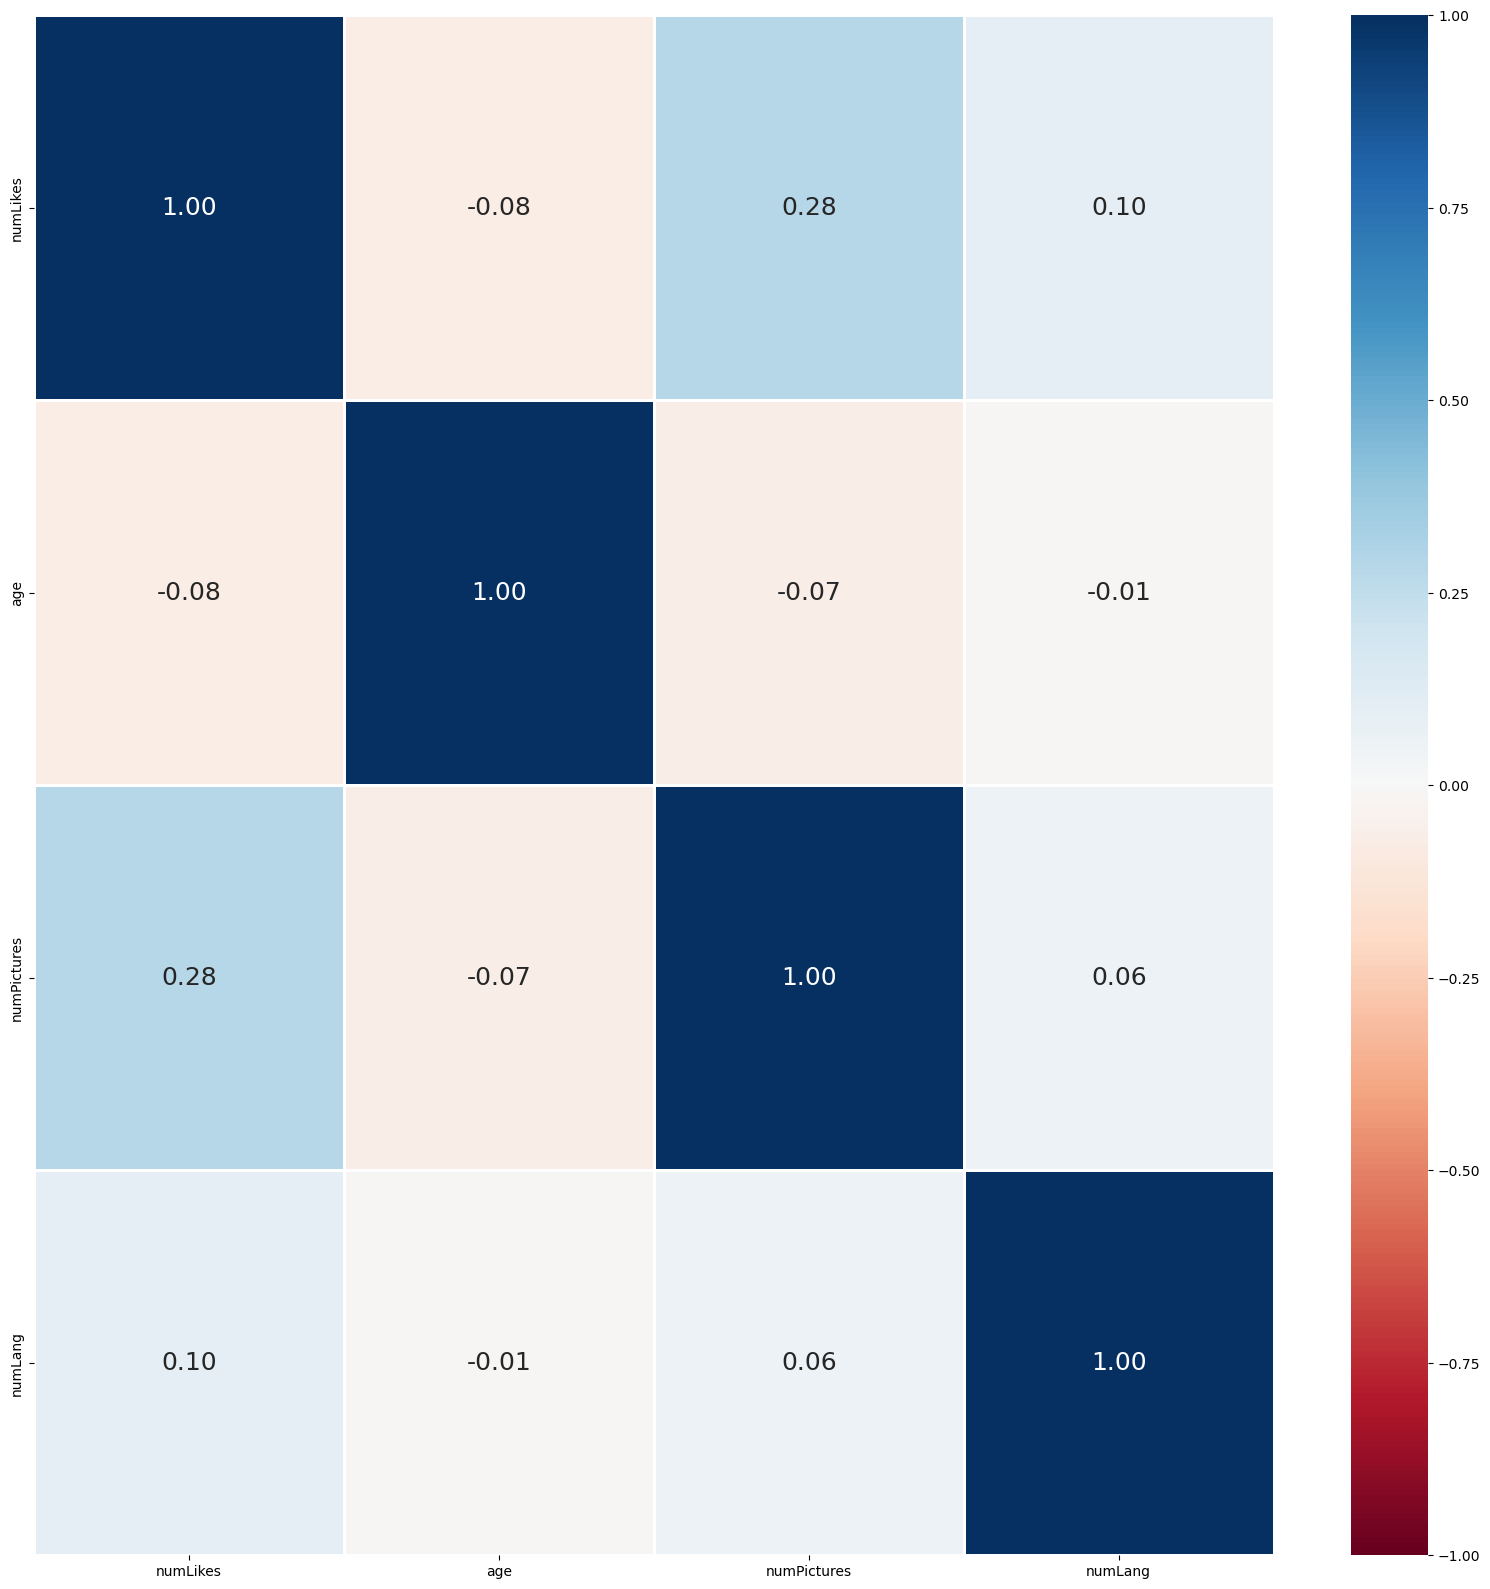

In [20]:
# Correlation Matrix
print(numeric_data.corr())

# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(20, 20))
sb.heatmap(numeric_data.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

We conclude from the heatmap the following:
1. numLikes has a positive linear relation with numPictures and numLang
2. numLikes has a negative linear relation with age
3. numLikes has a weak linear correlation with numLang and age (r <= 0.10)

As such, we will primarily be using numPictures for further numerical analysis.

### 2b. Categorical EDA
1. Univariate non-graphical
2. Univariate graphical
3. Multivariate graphical

1. **Univariate nongraphical** <br>
We inspect the numbers and proportions of each category in this section

In [21]:
print("Gender interest numbers")
print(df1['genderLooking'].value_counts(), '\n')
print("Gender interest proportions")
print(df1['genderLooking'].value_counts(normalize=True))

Gender interest numbers
1    2619
0     329
Name: genderLooking, dtype: int64 

Gender interest proportions
1    0.888399
0    0.111601
Name: genderLooking, dtype: float64


In [22]:
print("VIP Subscriber numbers")
print(df1['isVip'].value_counts(), '\n')
print("VIP Subscriber proportions")
print(df1['isVip'].value_counts(normalize=True))

VIP Subscriber numbers
0    2873
1      75
Name: isVip, dtype: int64 

VIP Subscriber proportions
0    0.974559
1    0.025441
Name: isVip, dtype: float64


In [23]:
print("User country numbers")
print(df1['country'].value_counts(), '\n')
print("User country proportions")
print(df1['country'].value_counts(normalize=True))

User country numbers
CH    1247
DE    1044
FR     542
IT     105
AT      10
Name: country, dtype: int64 

User country proportions
CH    0.422999
DE    0.354138
FR    0.183853
IT    0.035617
AT    0.003392
Name: country, dtype: float64


2. **Univariate graphical** <br>
We inspect the visualised proportions using barplots, then the visualised distributions using boxplots.

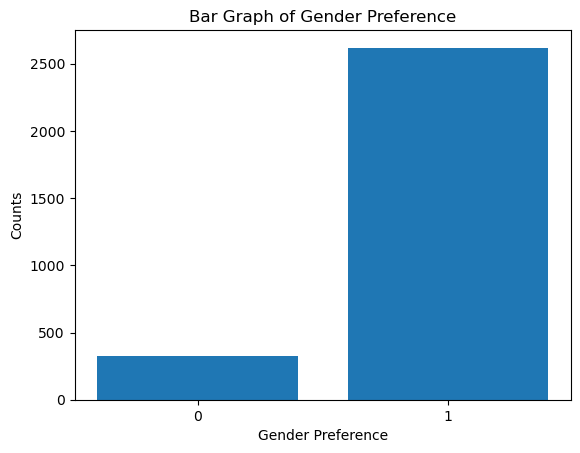

In [24]:
gender_counts = df1['genderLooking'].value_counts()

x_labels = gender_counts.index
y_values = gender_counts.values

plt.bar(x_labels, y_values)

plt.xlabel('Gender Preference')
plt.ylabel('Counts')
plt.title('Bar Graph of Gender Preference')

plt.xticks([0,1])

plt.show()

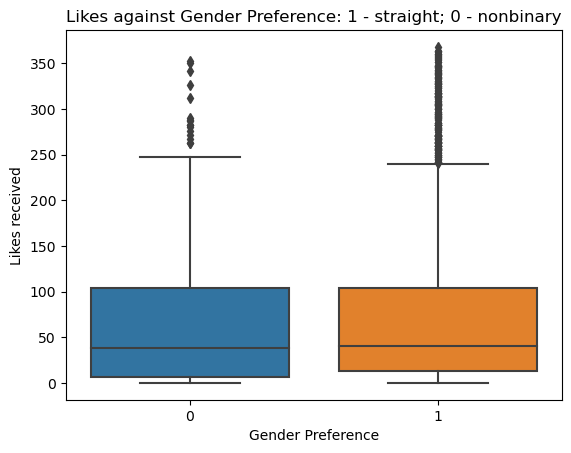

In [25]:
sb.boxplot(x='genderLooking', y='numLikes', data=df1)

# add x and y labels and a title
plt.xlabel('Gender Preference')
plt.ylabel('Likes received')
plt.title('Likes against Gender Preference: 1 - straight; 0 - nonbinary')

# show the plot
plt.show()

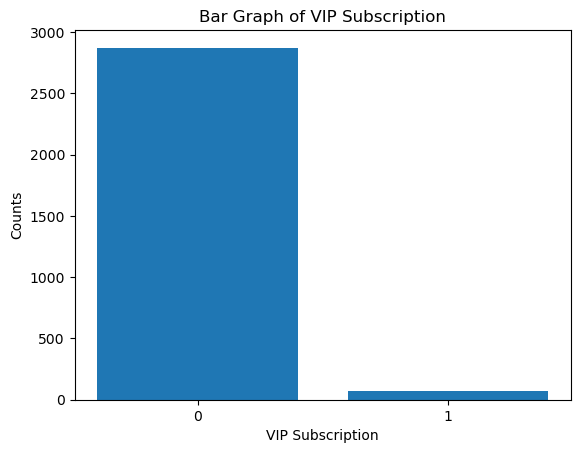

In [26]:
vip_counts = df1['isVip'].value_counts()

x_labels = vip_counts.index
y_values = vip_counts.values

plt.bar(x_labels, y_values)

plt.xlabel('VIP Subscription')
plt.ylabel('Counts')
plt.title('Bar Graph of VIP Subscription')

plt.xticks([0,1])

plt.show()

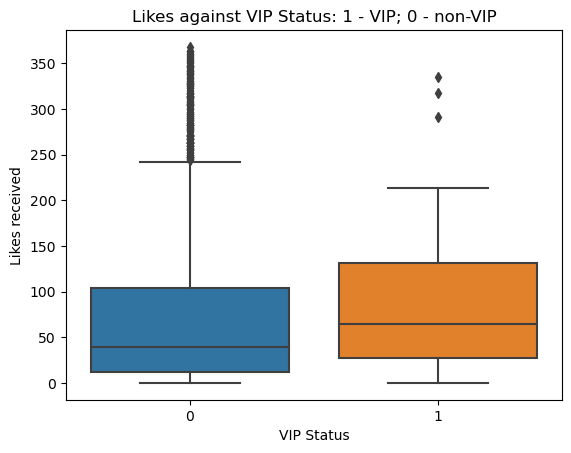

In [27]:
sb.boxplot(x='isVip', y='numLikes', data=df1)

# add x and y labels and a title
plt.xlabel('VIP Status')
plt.ylabel('Likes received')
plt.title('Likes against VIP Status: 1 - VIP; 0 - non-VIP')

# show the plot
plt.show()

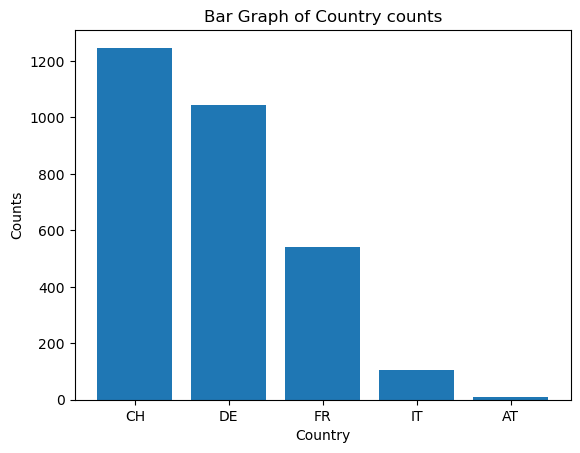

In [28]:
country_counts = df1['country'].value_counts()

x_labels = country_counts.index
y_values = country_counts.values

plt.bar(x_labels, y_values)

plt.xlabel('Country')
plt.ylabel('Counts')
plt.title('Bar Graph of Country counts')



plt.show()

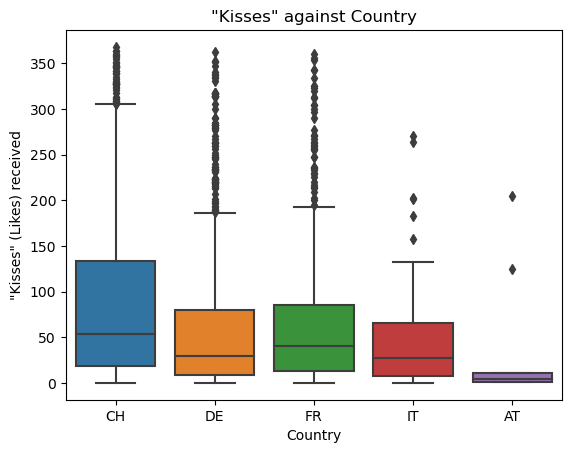

In [29]:
sb.boxplot(x='country', y='numLikes', data=df1)

# add x and y labels and a title
plt.xlabel('Country')
plt.ylabel('"Kisses" (Likes) received')
plt.title('"Kisses" against Country')

# show the plot
plt.show()

We use a layered histogram here to see the distribution of age groups for VIP subscribers. 
As we can see, there are the most VIP subscribers by proportion at lower ages, indicating that younger users are the most likely to buy subscription.

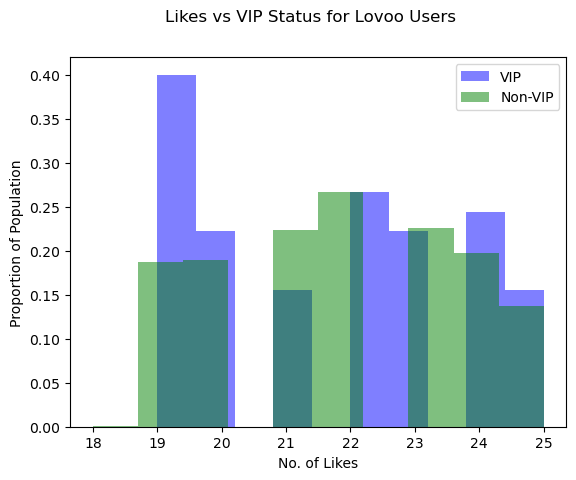

In [30]:
fig, ax = plt.subplots()

ax.hist(df1[df1["isVip"]==1]["age"], bins=10, alpha=0.5, color="blue", label="VIP", density=True)
ax.hist(df1[df1["isVip"]==0]["age"], bins=10, alpha=0.5, color="green", label="Non-VIP", density=True)

ax.set_xlabel("No. of Likes")
ax.set_ylabel("Proportion of Population")

fig.suptitle("Likes vs VIP Status for Lovoo Users")

# ax.set_xlim(0,4200)

ax.legend();

Next, we will use a layered histogram to see the distribution of likes for both VIP and non-VIP users. 
As we can see, the distribution of VIP users is more right-skewed than non-VIP, indicating a higher median and mean for the VIP users.

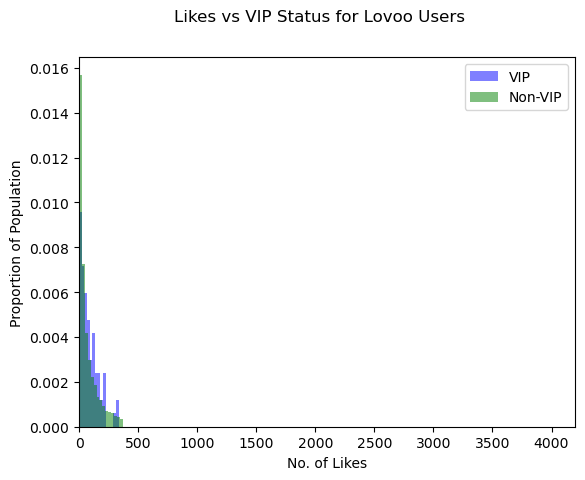

In [31]:
fig, ax = plt.subplots()

ax.hist(df1[df1["isVip"]==1]["numLikes"], bins=15, alpha=0.5, color="blue", label="VIP", density=True)
ax.hist(df1[df1["isVip"]==0]["numLikes"], bins=15, alpha=0.5, color="green", label="Non-VIP", density=True)

ax.set_xlabel("No. of Likes")
ax.set_ylabel("Proportion of Population")

fig.suptitle("Likes vs VIP Status for Lovoo Users")

ax.set_xlim(0,4200)

ax.legend();

In summary, the boxplots of the categorical data tell us the most:
- genderLooking does not appear to have a significant impact on the distribution of likes.
- isVip tells us VIP users tend to get slightly more likes (higher median, lower IQR)
- Swiss (CH) and French (FR) girls tend to get more likes judging on median, but it is not conclusive due to their higher IQR spread.<br>

We will keep all 3 categorical variables in consideration moving forward.

### Section 3: Machine Learning


3a. **Linear Regression Model of NumLikes against NumPictures**<br>
As mentioned above, we will use numPictures due to its highest correlation coefficient with respect to numLikes.

In [32]:
cp = pd.DataFrame(df1['numPictures'])  

ck = pd.DataFrame(df1['numLikes'])

In [33]:
# Split the Dataset into Train and Test - 0.2 because we want 20% test, 80% train
X_train1, X_test1, y_train1, y_test1 = train_test_split(cp, ck, test_size = 0.2)

# Linear Regression using Train Data
linreg1 = LinearRegression()         # create the linear regression object
linreg1.fit(X_train1, y_train1)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg1.intercept_)
print('Coefficients of Regression \t: a = ', linreg1.coef_)

# Predict Total values corresponding to HP
y_train_pred1 = linreg1.predict(X_train1)
y_test_pred1 = linreg1.predict(X_test1)

Intercept of Regression 	: b =  [37.46137446]
Coefficients of Regression 	: a =  [[8.94151264]]


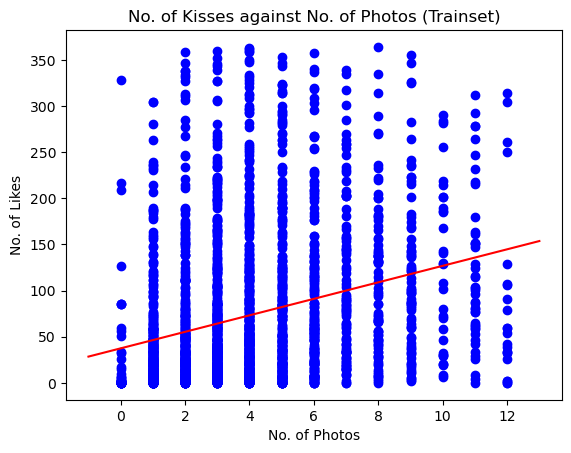

In [34]:
y_intercept1 = linreg1.intercept_
slope1 = linreg1.coef_[0]
plt.scatter(X_train1, y_train1, color='blue')
x1 = np.linspace(-1,13,25)
y1 = slope1*x1+y_intercept1
plt.plot(x1, y1, color='red')
plt.xlabel("No. of Photos")
plt.ylabel("No. of Likes")
plt.title("No. of Kisses against No. of Photos (Trainset)")
plt.show()

In [35]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model 1 (No. of Kisses against No. of Photos) \tTrain Dataset")
print("Explained Variance (R^2) \t:", round(linreg1.score(X_train1, y_train1),4))
print("Mean Squared Error (MSE) \t:", round(mean_squared_error(y_train1, y_train_pred1),4))
print()

# Check the Prediction Accuracy (on Test Data)
print("Prediction Accuracy of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", round(linreg1.score(X_test1, y_test1),4))
print("Mean Squared Error (MSE) \t:", round(mean_squared_error(y_test1, y_test_pred1),4))

Goodness of Fit of Model 1 (No. of Kisses against No. of Photos) 	Train Dataset
Explained Variance (R^2) 	: 0.0792
Mean Squared Error (MSE) 	: 6129.7126

Prediction Accuracy of Model 	Test Dataset
Explained Variance (R^2) 	: 0.0817
Mean Squared Error (MSE) 	: 6417.3714


Judging from our results, there is indeed a positive linear relation between number of likes and number of pictures uploaded, albeit a weak relation. <br> (r ~= +0.31, for the Test dataset)<br>
We can hence conclude that in general, users receive more likes when they are more comfortable putting up pictures of themselves on the app.


3b. **Chi-Square test between Categorical variables and numLikes**<br>
We will discretise numLikes by splitting it into two distinct sets: above median (1) and below median (0) <br>
For the Chi-Square test, we will perform a hypothesis test to determine if each of these categorical variables are good predictors for numLikes. We shall set our significance threshold at 5%.<br><br>

The chi2 statistic indicates to us the difference between observed and expected frequencies of VIP users below and above the median<br>
The p-value suggests to us the probability that we attain this distribution (or more extreme) assuming the 2 variables are unrelated

In [36]:
df1["discretised_counts"] = df1["numLikes"].apply(lambda x: 0 if x <= df1['numLikes'].median() else 1)


### isVip

In [37]:
ctab = pd.crosstab(df1['isVip'], df1['discretised_counts'])
ctab

discretised_counts,0,1
isVip,,
0,1447,1426
1,28,47


In [38]:
chi2, pval, dof, expected = chi2_contingency(ctab)
print("Chi2 value: ", round(chi2,4))
print("pval value: ", round(pval,4))

Chi2 value:  4.4579
pval value:  0.0347


We therefore conclude, since pval < sig level (0.0347 < 0.05), the isVip variable is a reasonable predictor of numLikes.

### Country

In [39]:
ctab2 = pd.crosstab(df1['country'], df1['discretised_counts'])
ctab2

discretised_counts,0,1
country,,
AT,8,2
CH,526,721
DE,610,434
FR,270,272
IT,61,44


In [40]:
chi2, pval, dof, expected = chi2_contingency(ctab2)
print("Chi2 value: ", round(chi2,4))
print("pval value: ", round(pval,16))

Chi2 value:  66.5221
pval value:  1.229e-13


Again, due to the extremely small pval in the order of e-13, country is also a reasonable predictor for numLikes

### genderLooking

In [41]:
ctab3 = pd.crosstab(df1['genderLooking'], df1['discretised_counts'])
ctab3

discretised_counts,0,1
genderLooking,,
0,167,162
1,1308,1311


In [42]:
chi2, pval, dof, expected = chi2_contingency(ctab3)
print("Chi2 value: ", round(chi2,4))
print("pval value: ", round(pval,4))

Chi2 value:  0.0488
pval value:  0.8252


genderLooking appears to be a poor predictor of numLikes, with its pval significantly above the threshold (0.8252 > 0.05).

3c. **Unsupervised learning using K-Means Clustering; using age and numPics and numLikes to cluster points.**
We will use these 4 variables as if they are coordinates in a 4D space, plotting them as such. The scikit-learn K-Means will be helping us to find the clusters for these points.<br>
Through this, we aim to find the key differences between clusters that will explain difference in number of likes the best.

In [43]:
norm_df = pd.DataFrame(df1[['numLikes', 'age', 'numPictures', 'isVip']])
norm_df = (norm_df-norm_df.min())/(norm_df.max()-norm_df.min())

In [44]:
i=0

model = KMeans(n_clusters = 3)
vipList = [list(x) for x in zip(norm_df['age'], norm_df['numPictures'], norm_df['numLikes'], norm_df['isVip'])]
model.fit(vipList)
labels = model.predict(vipList)

print("Model Inertia: ", model.inertia_, '\n\n\n')
print("Cluster centres:\n")
for i in range(3):
    print("Centre ", i+1, ':\n')
    print("Age: ", round(model.cluster_centers_[i][0]*7+18,4), '\n')
    print("No of Pictures: ", round(model.cluster_centers_[i][1]*12,4), '\n')
    print("VIP Status: ", round(model.cluster_centers_[i][3],4), '\n')
    print("No. of Likes: ", round(model.cluster_centers_[i][2]*368,4), '\n\n\n')
    i+=1
    

Model Inertia:  317.58523149280353 



Cluster centres:

Centre  1 :

Age:  21.717 

No of Pictures:  6.2654 

VIP Status:  0.0527 

No. of Likes:  202.8875 



Centre  2 :

Age:  23.3285 

No of Pictures:  3.3104 

VIP Status:  0.0195 

No. of Likes:  37.8046 



Centre  3 :

Age:  20.0201 

No of Pictures:  3.6339 

VIP Status:  0.0181 

No. of Likes:  45.3099 





As we can see, among the three clusters, Age and VIP status are not key differing characteristics. This tells us that in general:
- Age does not make a big difference in the 18-25 age range, in terms of number of likes receives
- Buying VIP does not significantly affect number of likes users receive
The key differences are instead numPictures and numLikes. As we can see in the 3 clusters:
1. Cluster 1 - mean 3.5 pictures and 24.5 likes
2. Cluster 2 - mean 5.3 pictures and 265 likes
3. Cluster 3 - mean 4.9 pictures and 122 likes

This suggests that in general, to "belong" to a cluster with larger number of likes, it is most effective to add more pictures to your profile.

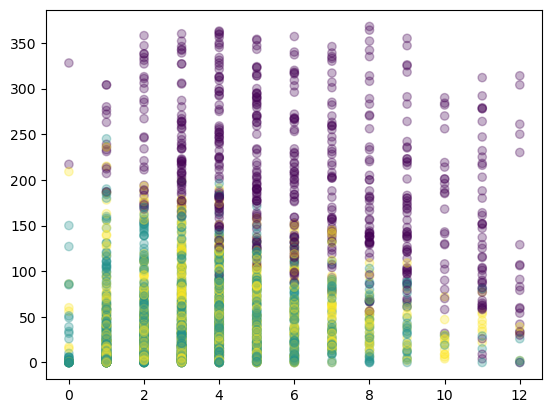

In [45]:
x = df1['numPictures'].values.tolist()
y = df1['numLikes'].values.tolist()
plt.scatter(x, y, c=labels, alpha=0.3)  

Finally, we want to find the ideal number of clusters (k), such inertia is as low as possible without incurring too much cost in number of clusters to find. <br>
We will do this by the Elbow Method, plotting inertia for each k (from 1 to 8).<br>
The point at the "Elbow", or turning point, in this case k=3, is the k value that minimises inertia at a reasonable cost.<br>
We hence conclude k=3 is idea for our K-Means learning.

C:\Users\Yong Jie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


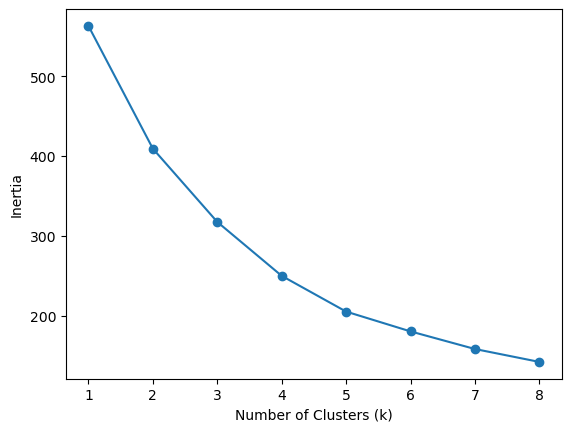

In [46]:
num_clusters = list(range(1,9))
inertias = []
for k in num_clusters:
  model = KMeans(n_clusters=k)
  model.fit(vipList)
  inertias.append(model.inertia_)

plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()
